In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from multiprocessing import  Pool
from astropy.io import ascii
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
# Import
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
all_stars = Table.read('../../HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
all_stars.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
all_stars = all_stars.set_index('ID')
all_stars = all_stars[(all_stars['ha_1']>5)&(all_stars['ha_1']<50)]
all_stars = all_stars[(all_stars['v_1']>5)&(all_stars['v_1']<50)]
all_stars = all_stars[(all_stars['i_1']>5)&(all_stars['i_1']<50)]

<h3>Classes and definitions</h3>

In [15]:
################################################################
### Read from unaltered FLT frames with regridded whitelights###
################################################################
class read_sexcats():
    def __init__(self):
        phot_df = self.join(1)
        self.phot_df = self.join(2, phot_df)
        #phot_df = self.return_func(phot_df)
        
    def join(self, wfc, phot_df=None):
        items = np.sort([w.split('_flt')[0] for w in glob('../SingleFrame_DetRegrid/WFC'+str(wfc)+'/*phot.fits')])
        items = items
        for iterator in range(len(items)):
            item = items[iterator]
            hdul = fits.open(glob(item+'*pamcorr_rate*')[0])
            expstart = hdul[0].header['EXPSTART']
            EXPTIME  = hdul[0].header['EXPTIME']
            if EXPTIME < 31: # For now skip all short exposures
                continue
            filter_  = hdul[0].header['FILTER']
            filename = glob(item+'*phot*')[0]
            sexcat = Table.read(filename, format="fits", hdu='LDAC_OBJECTS')#.to_pandas()
            sexcat = self.unpack_apers(sexcat)
            sexcat.remove_columns(['MAG_APER', 'MAGERR_APER', 'FLUX_APER', 'FLUXERR_APER'])    
            sexcat = sexcat.to_pandas()

            sexcat = sexcat.rename(columns={'NUMBER':'SExID'})
            sexcat = sexcat.rename(columns={'VECTOR_ASSOC':'AssocID'})
            #sexcat['AssocID'] = 1
            sexcat['Filename'] = filename.replace('phot', 'pamcorr_rate')
            sexcat['AssocID'] = sexcat['AssocID'].astype(int)
            sexcat = sexcat[sexcat.AssocID!=0]
            
            sexcat['SEx_ALPHA_J2000'] = sexcat['ALPHA_J2000'].values
            sexcat['SEx_DELTA_J2000'] = sexcat['DELTA_J2000'].values
            
            sexcat['ALPHA_J2000'] = all_stars.loc[sexcat['AssocID'].values].RA.values
            sexcat['DELTA_J2000'] = all_stars.loc[sexcat['AssocID'].values].Dec.values
            
            if wfc==2: 
                sexcat.SExID += phot_df[phot_df.WhichWFC==1].SExID.max()
            #sexcat = sexcat.rename(columns={'VECTOR_ASSOC':'ID'})

            sexcat['T_Start'] = expstart
            sexcat['Exptime'] = EXPTIME
            sexcat['Exp_Length'] = ('deep' if EXPTIME > 31 else 'short')
            sexcat['Filter']     = filter_
            sexcat['WhichWFC']   = wfc
            sexcat = self.clean(sexcat)
            #sexcat = sexcat.set_index('ID')
            try:
                phot_df = pd.concat((phot_df,sexcat), axis=0)
            except:
                phot_df = sexcat
        return phot_df
        
    def return_func(self):
        print('Done. Returning photometry dataframe')
        return self.phot_df.set_index(['AssocID', 'Filter', 'T_Start']).sort_index()
    
    def clean(self, sexcat):
        """I take all rules from the HCV catalogue"""
        sexcat = sexcat[(sexcat.MAG_APER2<80)&(sexcat.MAG_AUTO<80)]
        sexcat = sexcat[sexcat.MAG_APER2<31.0]
        sexcat = sexcat[sexcat.MAG_AUTO<35.0]
        sexcat = sexcat[sexcat.FLAGS<7]
        sexcat = sexcat[sexcat.FLAGS_WEIGHT!=1]#==0]
        sexcat = sexcat[sexcat.MAGERR_APER2<1]
        return sexcat
    
    def unpack_apers(self, sexcat):
        """Unpacking the stacked lists
           NOTES:
           APER1 and APER2 refer to Whitmore et al 2016 (2.5 and 7.5 pixels diameter)
           APER3 refers to our own aperture, which is 6 pixels in diameter
           """
        sexcat['FLUX_APER1'] = [w[0] for w in sexcat['FLUX_APER']]
        sexcat['FLUX_APER3'] = [w[1] for w in sexcat['FLUX_APER']]
        sexcat['FLUX_APER2'] = [w[2] for w in sexcat['FLUX_APER']]
        sexcat['FLUXERR_APER1'] = [w[0] for w in sexcat['FLUXERR_APER']]
        sexcat['FLUXERR_APER3'] = [w[1] for w in sexcat['FLUXERR_APER']]
        sexcat['FLUXERR_APER2'] = [w[2] for w in sexcat['FLUXERR_APER']]

        sexcat['MAG_APER1'] = [w[0] for w in sexcat['MAG_APER']]
        sexcat['MAG_APER3'] = [w[1] for w in sexcat['MAG_APER']]
        sexcat['MAG_APER2'] = [w[2] for w in sexcat['MAG_APER']]
        sexcat['MAGERR_APER1'] = [w[0] for w in sexcat['MAGERR_APER']]
        sexcat['MAGERR_APER3'] = [w[1] for w in sexcat['MAGERR_APER']]
        sexcat['MAGERR_APER2'] = [w[2] for w in sexcat['MAGERR_APER']]
        return sexcat


In [8]:
class HCV_error_analysis():
    def __init__(self, phot_df):
        self.phot_df = phot_df
        return

    def get_CI(self,phot_df):
        CI = phot_df['MAG_APER1'] - phot_df['MAG_APER2']
        phot_df['CI'] = CI
        return phot_df

    def get_synthetic_err(self,phot_df):
        """Following the approach of the HCV paper"""
        # I take the median, but note that there is always only ONE count, thus median = value
        MagerrAper2  = phot_df.groupby(['AssocID', 'Filter','T_Start'])['MAGERR_APER2'].median()
        MagerrAper2_timemedian = phot_df.groupby(['AssocID', 'Filter'])['MAGERR_APER2'].median()
        MagDivision = (MagerrAper2 / MagerrAper2_timemedian)**2
        
        CI_timemedian = phot_df.CI.groupby(['AssocID', 'Filter']).median()
        CIDivision    = (phot_df.CI / CI_timemedian)**2
        
        MagAper_MagAuto = (phot_df.MAG_APER2 - phot_df.MAG_AUTO)
        MagAper_MagAuto_timemedian = MagAper_MagAuto.groupby(['AssocID', 'Filter']).median()
        MagAper_MagAutoDivision = (MagAper_MagAuto/MagAper_MagAuto_timemedian)**2
        
        RATimemedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['SEx_ALPHA_J2000'].median()
        DECTimemedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['SEx_DELTA_J2000'].median()

        RAs = phot_df.groupby(['AssocID','Filter'])['SEx_ALPHA_J2000'].median()
        DECs = phot_df.groupby(['AssocID', 'Filter'])['SEx_DELTA_J2000'].median()

        DeltaRAs = np.power(RAs - RATimemedian,2)
        DeltaDECs = np.power(DECs - DECTimemedian,2)

        Dists = np.sqrt(DeltaRAs+DeltaDECs)
        DistsTimemedian = Dists.groupby(['AssocID', 'Filter']).median()
        DistsDivision   = (Dists/DistsTimemedian)**2
        
        BgTimeMedian = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['BACKGROUND'].median()
        BgMedian     = phot_df.groupby(['AssocID', 'Filter'])['BACKGROUND'].median() 
        BgDeviation  = (BgTimeMedian / BgMedian -1)**2
        self.BgDeviation = BgDeviation
        
        SynError = np.sqrt(MagDivision + CIDivision + MagAper_MagAutoDivision + BgDeviation + DistsDivision)
        phot_df['SynError'] = SynError
        return phot_df
    
    def linfit(self,x,b):
        return 1/np.inf*x+b
    
    def get_sigma_prime(self, phot_df):
        StarIDs = phot_df.get_level_values(0).unique()
        for StarID in StarIDs:
            filters = phot_df.loc[StarIDs].index.get_level_values(0).unique()
    
    
    
    def get_synthetic_err_deviation(self, phot_df):
        SynErrorSTD = phot_df.groupby(['AssocID', 'Filter'])['SynError'].std() # Standard deviation of synthetic errors
        SynErrorMed = phot_df.groupby(['AssocID', 'Filter'])['SynError'].median() # median of synthetic errors
        SynErrorDev = (phot_df.SynError-SynErrorMed).abs()/SynErrorSTD # How many sigma is this measurement removed from the median
        phot_df['SynErrorDevSig'] = SynErrorDev.values
        phot_df['SynErrorMed'] = SynErrorMed
        phot_df['SynErrorSig'] = phot_df.SynError / SynErrorMed
        phot_df['High_sigma_syn'] = phot_df['SynErrorSig'] > 4
        return phot_df
    
    
    def robust_mean(self,mags, synerrs):
        mags = mags.values
        synerrs = synerrs.values
        synerrs = synerrs[np.argsort(mags)]
        mags = np.sort(mags)
        if len(mags)>5:
            to_drop = (len(mags)//6)
            mags = mags[to_drop:-to_drop]
            synerrs = synerrs[to_drop:-to_drop]
        weighted_mean = np.nansum(1/synerrs**2 * mags) / np.nansum(1/synerrs**2)
        return weighted_mean, np.sqrt(np.mean(np.power(mags-weighted_mean,2)))
    
    def get_mean_sigmaprime(self, phot_df):
        """This will take some time"""
        StarIDs = phot_df.index.get_level_values(0).unique().values
        phot_df['RobustMean'] = 0
        phot_df['RobustSigma'] = 0
        i=0
        for StarID in StarIDs:
            filters = phot_df.loc[StarID].index.get_level_values(0).unique()
            for this_filter in filters:
                sub_phot_df = phot_df.loc[StarID,this_filter]
                Lightcurve_SynErrors = sub_phot_df.SynError
                Lightcurve_mags = sub_phot_df.MAG_APER2
                TrueMag, SigmaPrime = self.robust_mean(Lightcurve_mags, Lightcurve_SynErrors)
                phot_df.loc[(StarID, this_filter,),'RobustMean'] = TrueMag
                phot_df.loc[(StarID, this_filter,),'RobustSigma']= SigmaPrime
        phot_df['SigmaPrimeDeviation'] = (phot_df['MAG_APER2'] - phot_df['RobustMean']).abs() / phot_df['RobustSigma']
        phot_df['High_sigma_prime'] = phot_df['SigmaPrimeDeviation'] > 4
        return phot_df
    
    def parallelize_df(self,df, func, n_cores=4):
        df_split = np.array_split(df, n_cores)
        pool = Pool(n_cores)
        df = pd.concat(pool.map(func, df_split))
        pool.close()
        pool.join()
        return df
    
        
    def get_local_mzp_corr(self, phot_df):
        phot_df['MagDiff'] = phot_df['MAG_APER2'] - phot_df['RobustMean']
        nearest = nearest_neighbours(phot_df)
        phot_df = phot_df[phot_df.Exp_Length == 'deep'].copy()
        
        IDs = phot_df.index.get_level_values(0).unique()
        phot_df['MZPCorr']=0
        for ID in IDs:
            neightbours = nearest.loc[ID]
            photometry = phot_df.loc[neightbours.values]
            MagOffset = photometry.groupby(['Filter', 'T_Start'])['MagDiff'].median()
            MagOffset = pd.DataFrame(MagOffset)
            MagOffset.columns = ['MZPCorr2']
            phot_df.loc[ID,'MZPCorr'] = pd.DataFrame(phot_df.loc[ID]).join(MagOffset)['MZPCorr2'].values
        phot_df['MAG_APER2_ORIG'] = phot_df['MAG_APER2']
        phot_df['MAG_APER2'] = phot_df['MAG_APER2'] - phot_df['MZPCorr']
        return phot_df
    
    def clean(self, MZPcorr=False):
        phot_df = self.get_CI(self.phot_df)
        phot_df = self.get_synthetic_err(phot_df)
        phot_df = self.get_synthetic_err_deviation(phot_df)
        phot_df = self.parallelize_df(phot_df,self.get_mean_sigmaprime)
        # Measurements with extreme varying background are probably not good!
        phot_df = phot_df[self.BgDeviation<0.5]
        if MZPcorr:
            phot_df = self.parallelize_df(phot_df, self.get_local_mzp_corr)#.get_local_mzp_corr(phot_df)
        phot_df = phot_df[phot_df.CI < 5]
        phot_df = phot_df[(np.logical_not(phot_df.High_sigma_prime))*(np.logical_not(phot_df.High_sigma_syn))]
        print('Done. Returning photometry dataframe including CI and synthetic errors and MZP correction')
        return phot_df


In [9]:
def SExToCat(phot_df, cat):
    SExCoordinates = phot_df.groupby('AssocID')['ALPHA_J2000', 'DELTA_J2000'].median()
    CatCoordinates = all_stars[['RA', 'Dec']]
    DeltaRA  = np.power(SExCoordinates.ALPHA_J2000.values - CatCoordinates.RA.values[:,np.newaxis],2, dtype=np.float32).T
    DeltaDec = np.power(SExCoordinates.DELTA_J2000.values - CatCoordinates.Dec.values[:,np.newaxis],2, dtype=np.float32).T
    Dists    = np.sqrt(DeltaRA + DeltaDec)
    Dists[Dists>1e-4] = np.nan
    del DeltaRA, DeltaDec
    Dists     = pd.DataFrame(Dists, index = SExCoordinates.index, columns=all_stars.index)
    Assoc_df  = pd.DataFrame({'RefCatID':Dists.idxmin(axis=1)})
    return Assoc_df.dropna()
def nearest_neighbours(phot_df, Nstars = 50):
    catalogue = phot_df.groupby('AssocID')['ALPHA_J2000', 'DELTA_J2000'].median()
    Nentries = len(catalogue)
    
    deltaRA  = np.memmap('deltaRA.temp' , dtype='float64', mode='w+', shape=(Nentries,Nentries))
    deltaDEC = np.memmap('deltaDec.temp', dtype='float64', mode='w+', shape=(Nentries,Nentries))
    
    deltaRA[:]  = catalogue.ALPHA_J2000.values - catalogue.ALPHA_J2000.values[:,np.newaxis]
    deltaDEC[:] = catalogue.DELTA_J2000.values - catalogue.DELTA_J2000.values[:,np.newaxis]
    
    deltaAngle = deltaRA**2 + deltaDEC**2
    del deltaRA, deltaDEC
    
    nearest = catalogue.index.values[np.argsort(deltaAngle, axis=1)] # To correct for ID <-> argument
    nearest = pd.DataFrame(nearest[:,1:Nstars+1], index=catalogue.index)
    return nearest

In [875]:
class Analysis():
    def __init__(self, phot_df):
        self.ApplySelection(phot_df)
        return

    def ApplySelection(self, phot_df):
        self.phot_df = phot_df#[phot_df.SynErrorDevSig<=20]
        self.phot_df = self.phot_df[self.phot_df.Exp_Length=='deep']
    
    def GetMADvalues(self):
        phot_df          = self.phot_df
        MedianMagTime    = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['MAG_APER2'].median()
        MedianMagOverall = phot_df.groupby(['AssocID', 'Filter'])['RobustMean'].median()
        MagOffset        = (MedianMagTime - MedianMagOverall).abs()
        self.MAD         = MagOffset.groupby(['AssocID', 'Filter']).median()
        return self.MAD
    
    def GetMedMags(self):
        self.MedMag = self.phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].median()
        return self.MedMag
    
    def GetMADPlot(self, filter_=None):
        self.GetMADvalues()
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=False, histtype='step', normed=False, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('PDF')
        plt.show()
        
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=True, histtype='step', normed=True, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('CDF')
        plt.show()
        
        self.GetMedMags()
        if filter_ !=None:
            med_mags = self.MedMag[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD[self.MAD.index.get_level_values(1)==filter_]
        else:
            med_mags = self.MedMag#[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD#[self.MAD.index.get_level_values(1)==filter_]
        plt.hist2d(med_mags, mad_vals, bins=(np.linspace(15,28,80), np.linspace(0,0.4,50)), cmap=plt.cm.jet)
        plt.xlabel('Median magnitude')
        plt.ylabel('MAG Value')
        plt.show()
        
    
    def DrawTrumpets(self,magcol = 'MAG_APER3', IDcol = 'AssocID'):
        phot_df = self.phot_df
        merrcol = magcol.replace('MAG', 'MERR')
        # Trumpet plot
        from matplotlib.colors import LogNorm
        magnitudes = phot_df[magcol]
        filters = magnitudes.index.get_level_values(1).unique()
        plt.figure(figsize=(20,10))
        num=0
        for filter_ in np.sort(filters):
            epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
            mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
            num+=1
            plt.subplot('23'+str(num))
            xs, ys = np.array([]), np.array([])
            for i in range(len(epochs)-1):
                mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
                join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
                join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
                median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
                join_mags = join_mags.join(median_mags)
                x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
                x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
                xs = np.hstack((xs,x))
                ys = np.hstack((ys,y))
            plt.hist2d(xs, ys, bins=(np.linspace(15,28,80), np.linspace(-3,3,150)), cmap='jet', cmin=15)
            plt.title(filter_, pad=-15)
            plt.ylabel('Delta Mag')
            plt.xlabel('Median magnitude')
            plt.ylim(-1,1)
            plt.xlim(14,27)
            if num in [1,4,7]:
                plt.ylabel('Delta Mag')
            else:
                plt.yticks([])
            if num in [4,5]:
                plt.xlabel('Median magnitude')
            else:
                plt.xticks([])
            plt.ylim(-1.5,1.5)
        plt.tight_layout()
        #plt.savefig('trumpet_diagrams.png', dpi=500)
        plt.show()

    def MAG_pdf(self, magcol = 'MAG_APER2',fluxcol='FLUX_APER2', IDcol = 'AssocID'):
        phot_df = self.phot_df
        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1), histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()


        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1),cumulative=True, histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()
    
    def GetNumberOfMeasurements(self):
        counts = self.phot_df['MAG_APER2'].groupby(['AssocID', 'Filter']).count()
        return counts
    
    def GetTimeSeries(self, AssocID = None, Filter=None):
        if not AssocID:
            MinMeasurements = 10
            WhichEntries    = self.GetNumberOfMeasurements()>MinMeasurements
            WhichEntries    = WhichEntries[WhichEntries]
            RandomRow       = np.random.randint(0,len(WhichEntries))
            AssocID         = WhichEntries.index.get_level_values(0)[RandomRow]
            Filter          = WhichEntries.index.get_level_values(1)[RandomRow]
        JulianDates = self.phot_df.loc[AssocID, Filter].reset_index().T_Start
        Magnitudes  = self.phot_df.loc[AssocID, Filter].MAG_APER2
        Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = self.phot_df.loc[AssocID, Filter].MAGERR_APER2
        
        plt.figure(figsize=(8,5))
        plt.title(Filter + ' mag '+np.round(self.phot_df.loc[AssocID, Filter]['RobustMean'].median(),3).astype(str))
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none', fmt='o', ecolor='black', capthick=2)
        #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
        plt.show()
        

    def median_mad_sigma(self):
        mags, mads = self.GetMedMags(), self.GetMADvalues()  
        mags = pd.DataFrame(mags)
        mags.columns = ['MAG']
        mads = pd.DataFrame(mads)
        mads.columns = ['MAD']
        # Drop first 0.5 mag and last 0.5 mag
        lower_thres = pd.DataFrame(mags.groupby('Filter').min()+0.5)#FilterMags.min()+0.5
        lower_thres.columns = ['LowerMagThresh']
        upper_thres = pd.DataFrame(mags.groupby('Filter').max()-0.5)##FilterMags.max()-0.5
        upper_thres.columns = ['UpperMagThresh']

        mags = pd.merge(mags, lower_thres, left_index=True,left_on='Filter', right_index=True)#, right_on='Filter')
        mags = pd.merge(mags, upper_thres, left_index=True,left_on='Filter', right_index=True)

        mags = mags[(mags.MAG>mags.LowerMagThresh)*(mags.MAG<mags.UpperMagThresh)]
        MagsMads = mags.copy()
        MagsMads = MagsMads.join(mads)

        MagsMads['MagBin'] = pd.cut(MagsMads['MAG'], bins=20)
        MedMadBin = pd.DataFrame(MagsMads.groupby('MagBin')['MAD'].median())
        MedMadBin.columns = ['MedMadBin']
        MagsMads = pd.merge(MagsMads,MedMadBin, left_on='MagBin', right_index=True)

        MagsMads['MADSigma'] = MagsMads['MAD'] / MagsMads['MedMadBin']
        return MagsMads
    
    def potential_candidates(self):
        MagsMads = self.median_mad_sigma()
        PotCandidates = MagsMads['MAD'].unstack()
        PotCandidates['NFilters'] = PotCandidates.count(axis=1)
        return PotCandidates
    
    def inspect(self,AssocID, Filter):
        local_phot_df = self.phot_df.loc[AssocID, Filter]
        local_phot_df = local_phot_df.sort_index()
        files = local_phot_df.Filename.values
        self.GetTimeSeries(AssocID, Filter)
        racenter, deccenter = local_phot_df.ALPHA_J2000.values[0], local_phot_df.DELTA_J2000.values[0]
        xs, ys = local_phot_df.X_IMAGE.values, local_phot_df.Y_IMAGE.values
        apert = str(3.25*0.04/3600)
        # Make region file
        tempfile = open('temp_ds9.reg', 'w')
        print(racenter, deccenter)
        #tempfile.write("""# Region file format: DS9 version 4.1 \nglobal color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \nfk5 \n""")
        #tempfile.write('point('+str(racenter)+','+str(deccenter)+')\n')
        #tempfile.write('circle('+str(racenter)+','+str(deccenter)+','+apert+')\n')
        tempfile.write('fk5; point '+str(racenter)+' '+str(deccenter)+ '\n')
        tempfile.write('fk5; circle '+str(racenter)+' '+str(deccenter) +' ' + apert+ '\n')
        for i in range(len(xs)):
            tempfile.write('physical; point '+str(xs[i])+' '+str(ys[i])+' # color=red\n')
            print(files[i], '  ', xs[i], '  ', ys[i])
        tempfile.close()
        
        ds9_command = 'ds9 -scale zscale -lock frame wcs -lock scale '
        ds9_command += '-lock colorbar yes '
        ds9_command += ' '.join(files)
        ds9_command += ' -regions skyformat degrees -regions load all temp_ds9.reg'
        os.system(ds9_command +' &')
        #os.system('rm -rf temp_ds9.reg')
        return 
    
    def get_mad_mag_nom(self, crop = False):
        mags = self.GetMedMags()
        mads = self.GetMADvalues()
        nmeas = self.GetNumberOfMeasurements()
        magmad = pd.DataFrame(mags).join(pd.DataFrame({'MAD':mads}))
        magmadn = magmad.join(pd.DataFrame({'Nmeas':nmeas}))
        madovermedmad = self.median_mad_sigma()
        magmadnmedmad = magmadn.join(madovermedmad['MADSigma'])
        if crop:
            magmadnmedmad = magmadnmedmad[(magmadnmedmad.Nmeas>=3)&(magmadnmedmad.MAD>=0.25)&(magmadnmedmad.MAG_APER2<=30)&(magmadnmedmad.MADSigma>2)]
        return magmadnmedmad
    
    def second_brightest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[1]
        else:
            return xsort[0]
    
    def get_max_ha(self):
        phot_df = self.phot_df
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        phot_df = phot_df[phot_df.index.get_level_values(1)=='F656N']
        max_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].min()[nmeas]
        second_max_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].apply(lambda x: self.second_brightest(x))[nmeas]
        ha_error_mag   = phot_df.groupby(['AssocID', 'Filter'])['MAGERR_APER2'].median()[nmeas]
        med_ha         = self.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N']
        maxmag_df      = pd.DataFrame({'MaxHa':max_ha_mag,'SecondMaxHa':second_max_ha,'MedHa':med_ha, 'HaErr': ha_error_mag})
        return maxmag_df.droplevel(1)
    
    def get_color(self, color1, color2):
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        MedMag = self.GetMedMags()[nmeas].unstack()
        mag1 = MedMag[color1]
        mag2 = MedMag[color2]
        return mag1.dropna(), mag2.dropna(), pd.DataFrame({'Color':(mag1-mag2).dropna()})
    
    def merge_color_maxha(self,color1, color2):
        V, I, VI = self.get_color('F555W','F814W')
        maxha = self.get_max_ha()
        df = pd.merge(VI, maxha, right_index=True, left_index=True)
        df = pd.merge(df, V, right_index=True, left_index=True)
        df = pd.merge(df, I, right_index=True, left_index=True)
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        nmeas = (nmeas[nmeas.index.get_level_values(1)=='F656N'].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color1].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color2].droplevel(1))
        return df[nmeas]

<h3>Code</h3>

In [ ]:
import time
phot_df = read_sexcats().return_func()

In [20]:
phot_df = HCV_error_analysis(phot_df).clean(MZPcorr=True)

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Done. Returning photometry dataframe including CI and synthetic errors and MZP correction


In [21]:
phot_df.to_pickle('MZPCleanedPhot_whitelightregrid.pickle')

In [22]:
phot_df.reset_index().groupby('Filter')['AssocID'].nunique()

Filter
F336W    12286
F438W    12877
F555W    12356
F656N     7841
F814W    13492
Name: AssocID, dtype: int64

In [876]:
Analyzer = Analysis(phot_df)

In [751]:
df = pd.DataFrame({'X' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['i_1'], 'Y' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['ha_1']})  #we build a dataframe from the data
_, bins=pd.qcut(df.X,70, retbins=True)
data_cut = pd.cut(df.X,bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
#plt.scatter(df.X,df.Y,color='k',alpha=.2,s=2)
#plt.plot(ret.X,ret.Y,'r--',lw=4,alpha=.8)

fit = np.polyfit(ret.X,ret.Y, 4)
#plt.plot(ret.X,np.poly1d(fit)(ret.X))
#plt.ylim(-0.5,7)
#plt.xlim(-0.5,3)
#plt.show()

def running_median(VI_color):
    return np.poly1d(fit)(VI_color)

In [878]:
df= Analyzer.merge_color_maxha('F555W','F814W')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:243: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


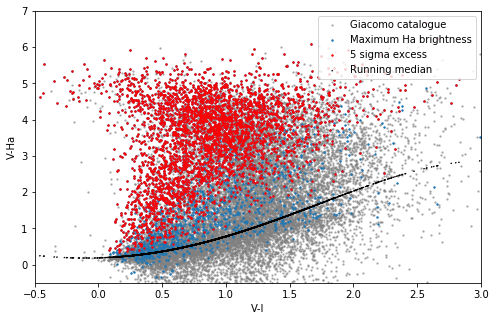

3268


In [911]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.MaxHa) - running_median(df.F555W-df.F814W))/df.HaErr>=3
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2,alpha=0.5, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.MaxHa, s=2, label='Maximum Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.MaxHa)[five_sigma_excess], s=2, c='red', label='5 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())

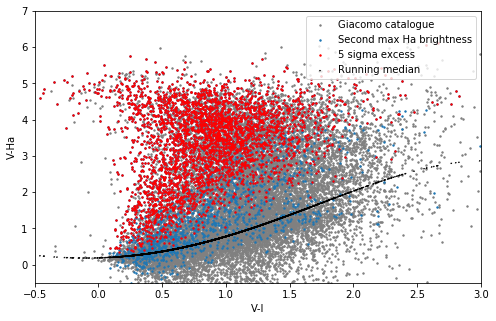

3071


In [912]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.SecondMaxHa) - running_median(df.F555W-df.F814W))/df.HaErr>=3
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='5 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())
ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

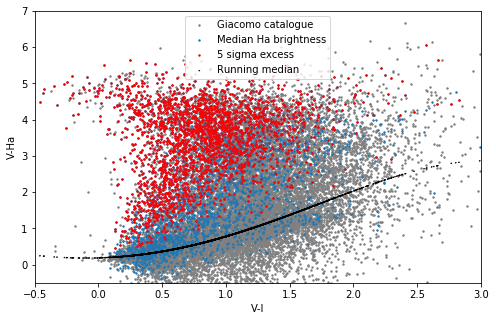

2416


In [889]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.MedHa) - running_median(df.F555W-df.F814W))/df.HaErr>=5
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.MedHa, s=2, label='Median Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.MedHa)[five_sigma_excess], s=2, c='red', label='5 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())

In [ ]:
print((((df.F555W-df.MaxHa) - running_median(df.F555W-df.F814W))>0.6).sum())
mads.loc[ha_excess_stars]

array([   13,    20,    22, ..., 22172, 22201, 22251])

In [913]:
mads = Analyzer.median_mad_sigma().MAD
mads = mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[ha_excess_stars]
print(len(excess_mad))
not_excess_mad = mads.loc[np.setdiff1d(mads.reset_index().AssocID, ha_excess_stars)]
print(len(not_excess_mad))

3048
4305


Text(0, 0.5, 'Frequency')

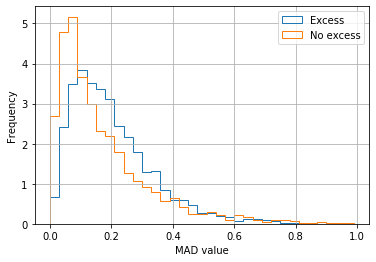

In [914]:
excess_mad.hist(bins=np.arange(0,1,0.03), histtype='step', label='Excess', normed=True)
not_excess_mad.hist(bins=np.arange(0,1,0.03), histtype='step', label='No excess', normed=True)
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

In [ ]:
((all_stars['v_1']-all_stars['ha_1']))#- running_median(all_stars['v_1']-all_stars['i_1']))#/all_stars['eha_2']

In [647]:
running_median(all_stars['v_1']-all_stars['i_1'])

array([  0.46880014,   0.3418285 ,   0.30894786, ...,  -1.05212882,
       -15.3474015 ,  -8.79091561])

In [24]:
a = Analyzer.get_mad_mag_nom()
a[a.index.get_level_values(1)== 'F656N']['Nmeas']

AssocID  Filter
3        F656N     4
61       F656N     2
111      F656N     2
127      F656N     3
132      F656N     2
                  ..
22016    F656N     5
22023    F656N     3
22088    F656N     3
22251    F656N     4
22286    F656N     5
Name: Nmeas, Length: 5949, dtype: int64

In [25]:
medmag = Analyzer.GetMedMags().unstack()

VminI = medmag.F555W-medmag.F814W
Vmag  = medmag.F555W

medmag = medmag.join(a[a.index.get_level_values(1)== 'F656N']['MAD'])

medmag = medmag.join(a[a.index.get_level_values(1)== 'F656N']['Nmeas'])
medmag = medmag.sort_values(ascending=False, by='MAD')
medmag['VminI'] = medmag.F555W-medmag.F814W
medmag['VminHa'] = medmag.F555W-medmag.F656N
medmag = medmag[medmag.Nmeas>2]

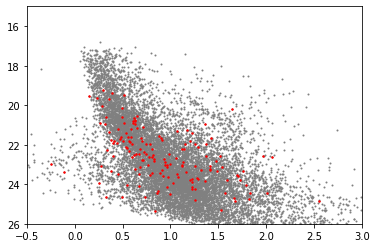

In [27]:
plt.scatter(VminI, Vmag, s=1, color='grey')
plt.scatter(medmag['VminI'][medmag.MAD>0.5], medmag['F555W'][medmag.MAD>0.5], s=2, color='red')

plt.ylim(26,15)
plt.xlim(-0.5,3)
plt.show()

In [28]:
xpoints = medmag['VminI']
ypoints = medmag['VminHa']

mask = (np.isfinite(xpoints))&(np.isfinite(ypoints))&(~np.isnan(xpoints))&(~np.isnan(ypoints))
xpoints = xpoints[mask]
ypoints = ypoints[mask]

In [ ]:
plt.scatter(xpoints, ypoints, s=1, color='grey')
plt.scatter(medmag['VminI'][medmag.MAD>0.5], medmag['VminHa'][medmag.MAD>0.5], s=3, color='red')
#plt.scatter(medmag['VminI'][medmag.MAD>0.3], medmag['F555W'][medmag.MAD>0.3], s=1, color='red')
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()

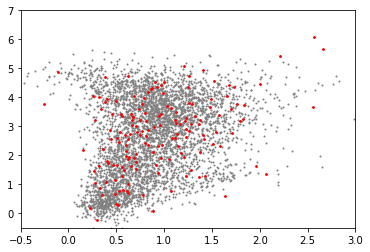

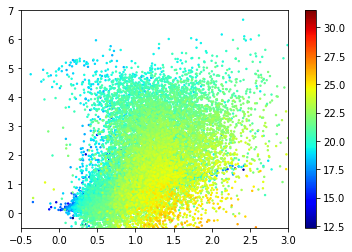

In [23]:
from mpl_toolkits.mplot3d import Axes3D
plt.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'],cmap='jet', s=2, c=all_stars['ha_1'])
#plt.scatter(medmag['F555W'] - medmag['F814W'],medmag['F555W'] - medmag['F656N'], s=1, c='red')
plt.colorbar()
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()


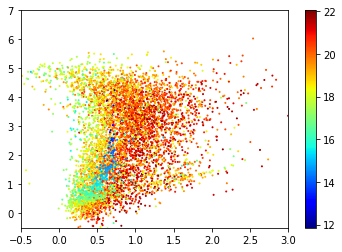

In [24]:
from mpl_toolkits.mplot3d import Axes3D
#plt.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'],cmap='jet', s=2, c=all_stars['ha_1'])
plt.scatter(medmag['F555W'] - medmag['F814W'],medmag['F555W'] - medmag['F656N'], s=1, cmap='jet', c=medmag['F656N'])
plt.colorbar()
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()

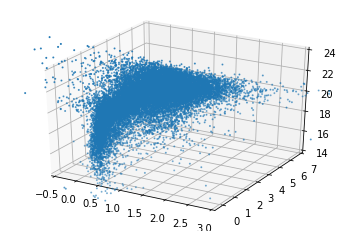

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'], all_stars['ha_1'], s=1)
ax.set_zlim(14,24)
#plt.scatter(all_stars['v_1'] - all_stars['i_1'],all_stars['v_1'] - all_stars['ha_1'], s=1, c='grey')
#plt.scatter(medmag['F555W'] - medmag['F814W'],medmag['F555W'] - medmag['F656N'], s=1, c='red')
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.show()

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


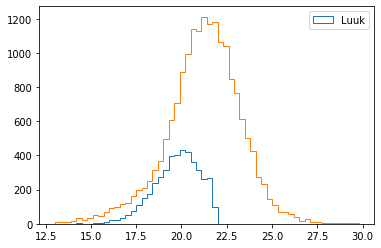

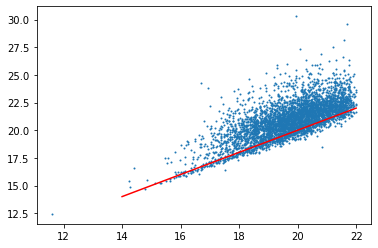

In [509]:
merged = pd.merge(medmag['F656N'].droplevel(1),all_stars['ha_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['F656N'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['ha_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['F656N'], merged.dropna()['ha_1'], s=1)
plt.plot([14,22], [14,22], color='red')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


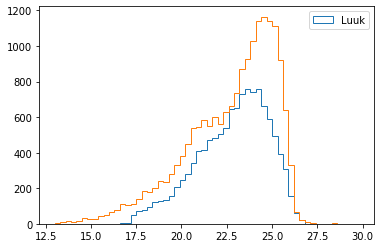

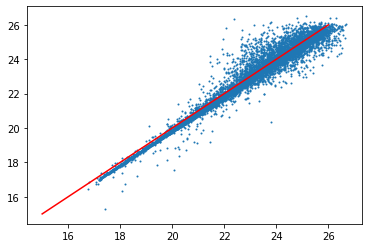

In [510]:
F555mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F555W'].droplevel(1)
merged = pd.merge(F555mags,all_stars['v_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG_APER2'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['v_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG_APER2'], merged.dropna()['v_1'], s=1)
plt.plot([15,26],[15,26], color='red')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


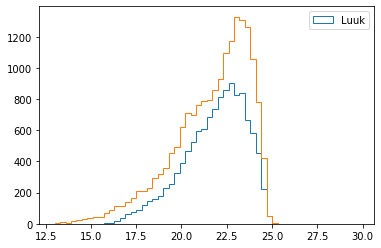

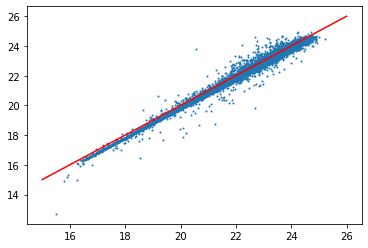

In [508]:
F814mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F814W'].droplevel(1)
merged = pd.merge(F814mags,all_stars['i_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG_APER2'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['i_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG_APER2'], merged.dropna()['i_1'], s=1)
plt.plot([15,26],[15,26], color='red')

In [45]:
a=phot_df.reset_index().groupby(['AssocID', 'Filter'])['T_Start'].nunique().sort_values(ascending=False)
a=a.reset_index()
a[a.Filter=='F656N']

,AssocID,Filter,T_Start
36526,7054,F656N,8
36529,1271,F656N,8
36530,957,F656N,8
36544,13093,F656N,8
36545,1761,F656N,8
...,...,...,...
62340,12667,F656N,1
62343,8560,F656N,1
62346,7067,F656N,1
62348,12665,F656N,1


In [175]:
phot_df.loc[7054, 'F656N'].MAG_APER2.values

array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191])

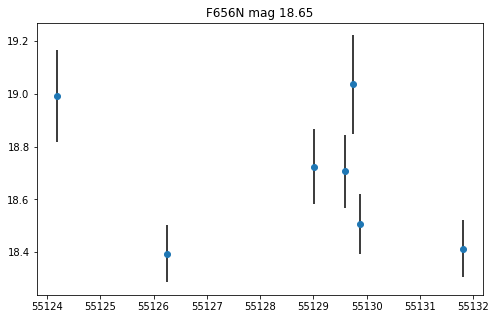

84.628175 -69.0692811
../SingleFrame_DetRegrid/WFC2/ib6wd1rrq_flt_wfc2_pamcorr_rate.fits    366.6078    748.23566
../SingleFrame_DetRegrid/WFC2/ib6wd4kvq_flt_wfc2_pamcorr_rate.fits    368.26678    791.9584
../SingleFrame_DetRegrid/WFC2/ib6wd2btq_flt_wfc2_pamcorr_rate.fits    360.462    748.94104
../SingleFrame_DetRegrid/WFC2/ib6wd3fdq_flt_wfc2_pamcorr_rate.fits    373.50534    790.1525
../SingleFrame_DetRegrid/WFC2/ib6wd5gdq_flt_wfc2_pamcorr_rate.fits    370.75998    749.021
../SingleFrame_DetRegrid/WFC2/ib6wd7hdq_flt_wfc2_pamcorr_rate.fits    378.586    791.3556
../SingleFrame_DetRegrid/WFC2/ib6wr8jhq_flt_wfc2_pamcorr_rate.fits    383.7915    788.8034


In [31]:
Analyzer.inspect(1950, 'F656N')
#Analyzer.inspect(3119, 'F656N')
#nalyzer.inspect(3411, 'F814W')
#Analyzer.inspect(2067, 'F656N')
#Analyzer.inspect(230, 'F656N')
#Analyzer.inspect(2196, 'F656N')

In [182]:
def create_lightcurve(T, randmodel):
    base_mag = 18
    if randmodel == 'sin':
        amp = np.random.randn()*0.4 + 0.5
        freq = np.random.randn()+0.5
        phaseshift = np.random.randn()*3.14
        lightcurve = amp*np.sin(freq*T-phaseshift) + 0.1*np.random.randn(len(T))+base_mag
    if randmodel=='heavyside2':
        amp = np.random.randn()*0.1 + 0.4
        probs = np.random.randn(3)*0.1+0.33
        probs = np.array([max(0,min(w,1)) for w in probs])
        probs = probs / np.nansum(probs)
        lightcurve = base_mag + 0.3*np.random.choice([-1,0,1],size=8, p=probs)+ 0.1*np.random.randn(len(T))
    if randmodel=='heavyside1':
        amp = np.random.randn()*0.1 + 0.4
        probs = np.random.randn(2)*0.1+0.5
        probs = np.array([max(0,min(w,1)) for w in probs])
        probs = probs / np.nansum(probs)
        lightcurve = base_mag + 0.3*np.random.choice([-1,0],size=8, p=probs)+ 0.1*np.random.randn(len(T))
    if randmodel == 'constant':
        lightcurve = base_mag + 0.1*np.random.randn(len(T))
    if randmodel == 'delta':
        npeaks = np.random.randint(0,5)
        lightcurve = base_mag + 0.1*np.random.randn(len(T))
        peaks = np.random.choice(range(0,8),size=npeaks)
        for peak in peaks:
            lightcurve[peak] -= (np.random.randn()*0.2+0.5)
    if randmodel == 'triangular':
        lightcurve = base_mag - 0.4*signal.triang(8)+ 0.1*np.random.randn(len(T)) 
    return lightcurve

def mad(vals):
    return np.median(np.abs(vals - np.median(vals)))

def minmax(vals):
    vals = np.sort(vals)[1:-1]
    return np.max(vals) - np.min(vals)


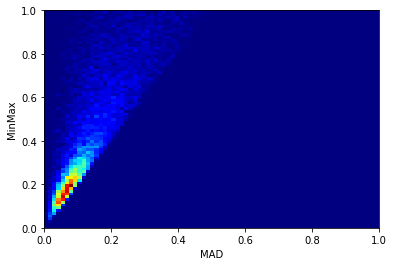

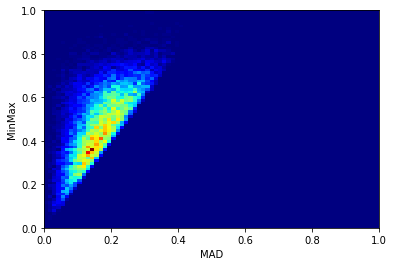

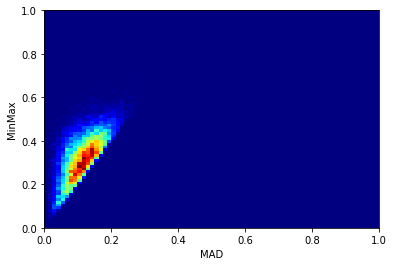

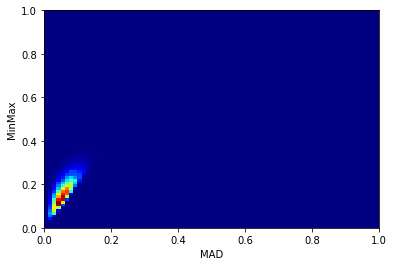

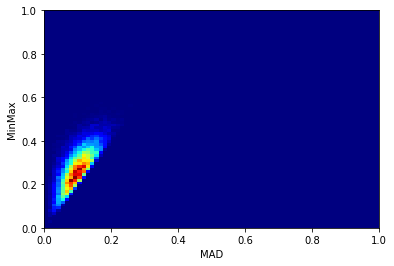

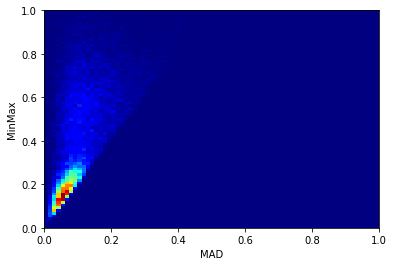

In [186]:
T = np.array([55124.18571567, 55126.24902567, 55129.00696583, 55129.59410694,
       55129.73546102, 55129.87522953, 55130.87543805, 55131.80321583])


for model in ['sin', 'heavyside2', 'heavyside1', 'constant', 'triangular', 'delta']:
    madvals=[]
    minmaxvals=[]
    for simulation in range(20000):
        lightcurve = create_lightcurve(T, model)
        madval = mad(lightcurve)
        madvals.append(madval)
        minmaxval = minmax(lightcurve)
        minmaxvals.append(minmaxval)
    plt.xlabel('MAD')
    plt.ylabel('MinMax')
    plt.hist2d(madvals, minmaxvals,bins=(np.linspace(0,1,80),np.linspace(0,1,80)), cmap='jet')
    plt.show()

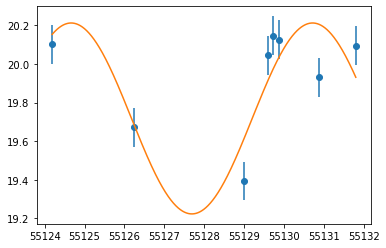

In [180]:
def sin(x, a, b, c,d):
    return a*np.sin(b*x-c)+d
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sin, T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]), sigma=8*[0.1])

plt.scatter(T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]))
plt.errorbar(T, np.array([20.10210643, 19.67172777, 19.39368394, 20.04486941, 20.14697961,
       20.12556658, 19.93001961, 20.09496191]), yerr=0.1, ls='none')

x=np.linspace(min(T), max(T), 10000)
plt.plot(x, sin(x, *popt))